## SPARC-4 mini-pipeline tools
***
# <font color='darkblue'>Stack science images</font> 

This notebook shows an example for reducing a series of scientific images using the SPARC4 pipeline to produce a master stacked image of a given field.

* Eder Martioli, LNA 20 Jun 2023

<div class="alert alert-block alert-warning">
<b>WARNING:</b> it requires running <b>sp4_bias_flat_calibration.ipynb</b> in advance to generate bias and flat calibrations
</div>

In [9]:
import os,sys
sys.path.append(os.path.dirname(os.getcwd()))
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_db as s4db

## User inputs

In [2]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "CR1"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 4  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# create database of raw data for reduction
db = s4db.create_db_from_observations(p['filelists'][CHANNEL-1], 
                                      p['DB_KEYS'], 
                                      include_img_statistics=p["INCLUDE_IMG_STATISTICS"], 
                                      include_only_fullframe=p["FULL_FRAMES_ONLY"], 
                                      output=p['s4db_files'][CHANNEL-1])

# detect all detector modes
detector_modes = s4db.get_detector_modes_observed(db, 
                                                  science_only=True,
                                                  detector_keys=p["DETECTOR_MODE_KEYWORDS"])
# get first valid key
mode_key = next(iter(detector_modes))

# we need the reduce directory 
reduce_ch_dir = p['reduce_directories'][CHANNEL-1]

# uncomment below to set maximum number of files for stacking
p['NFILES_FOR_STACK'] = 16

# set S/N threshold for detecting sources in stack
p['PHOT_THRESHOLD'] = 10

## Define input calibrations
Here is where one should define the following calibrations:
* Master bias
* Master flat
* A file containing the reference WCS for an astrometric solution

In [3]:
# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],
                                                          NIGHTDIR,
                                                          p['CHANNELS'][CHANNEL-1],
                                                          mode_key)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],
                                                              NIGHTDIR,
                                                              p['CHANNELS'][CHANNEL-1],
                                                              mode_key)
# set reference image for astrometry
p["ASTROM_REF_IMG"] = p["ASTROM_REF_IMGS"][CHANNEL-1]

## 1. To `STACK` images

In [5]:
# set PHOThometric or POLARimetric instrument mode
#inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']
inst_mode = p['INSTMODE_PHOTOMETRY_KEYVALUE']

# first get list of science data matching object, detector mode, and inst. mode
sci_list = s4db.get_file_list(db, 
                              object_id=OBJECTID, 
                              inst_mode=inst_mode, 
                              obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                              detector_mode=detector_modes[mode_key])


# set suffix for output stack filename
stack_suffix = "{}_s4c{}{}_{}".format(NIGHTDIR, 
                                      p['CHANNELS'][CHANNEL-1], 
                                      mode_key, 
                                      OBJECTID.replace(" ",""))

# calculate stack
p = s4pipelib.stack_science_images(p,
                                   sci_list,
                                   reduce_dir=reduce_ch_dir,
                                   force=FORCE,
                                   stack_suffix=stack_suffix,
                                   polarimetry=False)

There is already a stack image : /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_Gain2_1_Conventional_2_CR1_stack.fits


/Users/eder/anaconda3/lib/python3.7/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


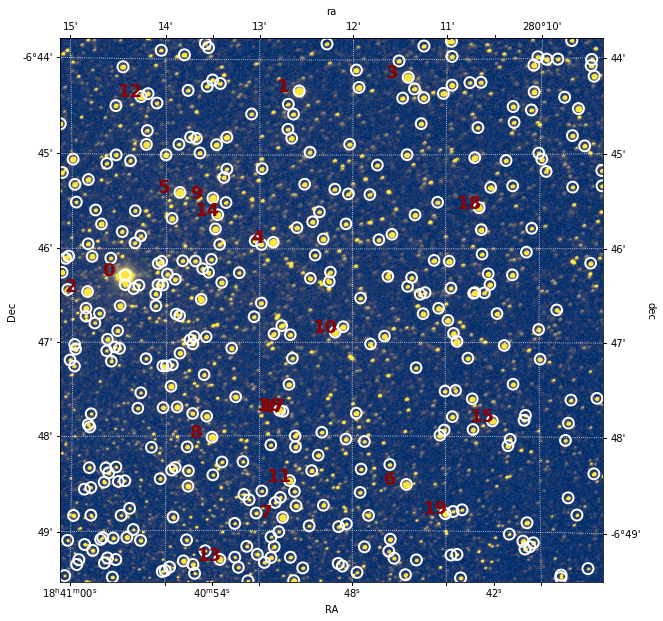

Stack image: /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503/20230503_s4c4_Gain2_1_Conventional_2_CR1_stack.fits


In [8]:
s4plt.plot_sci_frame(p['OBJECT_STACK'], nstars=20, use_sky_coords=True)
print("Stack image: {}".format(p['OBJECT_STACK']))